In [1]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls drive/MyDrive/crs/

CRS_2016_data_short.csv  crskor2011_2020.csv  glove.840B.300d.txt
crs_final_df_kor.csv	 data


In [4]:
!ls drive/MyDrive/crs/data/CRS 2016 data.txt

ls: cannot access 'drive/MyDrive/crs/data/CRS': No such file or directory
ls: cannot access '2016': No such file or directory
ls: cannot access 'data.txt': No such file or directory


In [5]:
data1 = pd.read_csv("drive/MyDrive/crs/crs_final_df_kor.csv", header = 0)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (6,58,59,90,91) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
data1.columns

Index(['Unnamed: 0', 'Year', 'DonorCode', 'DonorName', 'AgencyCode',
       'AgencyName', 'CrsID', 'ProjectNumber', 'InitialReport',
       'RecipientCode', 'RecipientName', 'RegionCode', 'RegionName',
       'IncomegroupCode', 'IncomegroupName', 'FlowCode', 'FlowName',
       'Bi_Multi', 'Category', 'Finance_t', 'Aid_t', 'USD_Commitment',
       'USD_Disbursement', 'USD_Received', 'USD_Commitment_Defl',
       'USD_Disbursement_Defl', 'USD_Received_Defl', 'USD_Adjustment',
       'USD_Adjustment_Defl', 'USD_AmountUntied', 'USD_AmountPartialTied',
       'USD_AmountTied', 'USD_AmountUntied_Defl', 'USD_AmountPartialTied_Defl',
       'USD_Amounttied_Defl', 'USD_IRTC', 'USD_Expert_Commitment',
       'USD_Expert_Extended', 'USD_Export_Credit', 'CurrencyCode',
       'Commitment_National', 'Disbursement_National', 'GrantEquiv',
       'USD_GrantEquiv', 'ShortDescription', 'ProjectTitle', 'PurposeCode',
       'PurposeName', 'SectorCode', 'SectorName', 'ChannelCode', 'ChannelName',
       

In [7]:
data = data1.loc[:,["PurposeCode","LongDescription","ProjectTitle", "ShortDescription"]]

In [8]:
data.head(2)

,PurposeCode,LongDescription,ProjectTitle,ShortDescription
0,12230.0,To provide medical equipment and consulting se...,Medical Equipment Sector Development Loan Project,MEDICAL EQUIPMENT SECTOR DEVELOPMENT LOAN PROJECT
1,31120.0,To educate governmental officials of developin...,Master's degree program in Rural Development(2...,MASTER'S DEGREE PROGRAM IN RURAL DEVELOPMENT(2...


In [13]:
data = data[pd.notnull(data['LongDescription'])] ; data.shape

(63977, 5)

In [9]:
data = data[data['LongDescription'].str.len() > 25].reset_index(drop=True).copy() ; data.shape

In [11]:
data['len'] = data['LongDescription'].apply(lambda s : len(s))

In [14]:
data.head(2)

,PurposeCode,LongDescription,ProjectTitle,ShortDescription,len
0,12230.0,To provide medical equipment and consulting se...,Medical Equipment Sector Development Loan Project,MEDICAL EQUIPMENT SECTOR DEVELOPMENT LOAN PROJECT,81
1,31120.0,To educate governmental officials of developin...,Master's degree program in Rural Development(2...,MASTER'S DEGREE PROGRAM IN RURAL DEVELOPMENT(2...,223


In [15]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

## Define CNN model

In [16]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

## Define BiLSTM

In [17]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

## With minimum requirement
- Over 100 classification

In [18]:
count_df = data[['PurposeCode','LongDescription']].groupby('PurposeCode').aggregate({'LongDescription':'count'}).reset_index().sort_values('LongDescription',ascending=False)
count_df.head()

,PurposeCode,LongDescription
85,22040.0,4791
46,15110.0,4635
13,11420.0,4387
4,11220.0,3356
5,11230.0,2949


In [19]:
target_code = count_df[count_df['LongDescription']>100]['PurposeCode'].values ; count_df.shape

In [21]:
count_df['PurposeCode'].unique()

array([22040., 15110., 11420., 11220., 11230., 11110., 11120., 31120.,
       43040., 11330., 12220., 16061., 12191., 11320., 31181., 16010.,
       99810., 21020., 21050., 15130., 12110., 72010., 11240., 11430.,
       22010., 43030., 11130., 43010., 32171., 41010., 12230., 31110.,
       15170., 14010., 32310., 74020., 15111., 25010., 14020., 33120.,
       31161., 33110., 32182., 14050., 21010., 12181., 31320., 23110.,
       23630., 12264., 31163., 33181., 15112., 24010., 12261., 31166.,
       15210., 32172., 21030., 13020., 41082., 32130., 33210., 43082.,
       12250., 91010., 16020., 15113., 14030., 16062., 22020., 32161.,
       41081., 16050., 23230., 31194., 31140., 32163., 12240., 15151.,
       31310., 31381., 23210., 32110., 15114., 31210., 15160., 72040.,
       31220., 43060., 31182., 22030., 21040., 23510., 31191., 16030.,
       99820., 14015., 11182., 16063., 23183., 33140., 15250., 11260.,
       12281., 31281., 31195., 32262., 31162., 32220., 73010., 14031.,
      

In [22]:
target_code

array([22040., 15110., 11420., 11220., 11230., 11110., 11120., 31120.,
       43040., 11330., 12220., 16061., 12191., 11320., 31181., 16010.,
       99810., 21020., 21050., 15130., 12110., 72010., 11240., 11430.,
       22010., 43030., 11130., 43010., 32171., 41010., 12230., 31110.,
       15170., 14010., 32310., 74020., 15111., 25010., 14020., 33120.,
       31161., 33110., 32182., 14050., 21010., 12181., 31320., 23110.,
       23630., 12264., 31163., 33181., 15112., 24010., 12261., 31166.,
       15210., 32172., 21030., 13020., 41082., 32130., 33210., 43082.,
       12250., 91010., 16020., 15113., 14030., 16062., 22020., 32161.,
       41081., 16050., 23230., 31194., 31140., 32163., 12240., 15151.,
       31310., 31381., 23210., 32110., 15114., 31210., 15160., 72040.,
       31220.])

In [23]:
# from google.colab import files
# count_df.to_csv('purpose_code.csv') 
# files.download('purpose_code.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
def condition_parser(x):
    if x in target_code:
        return x
    else:
        return "OTHER"
    
data['PurposeCode'] = data['PurposeCode'].apply(lambda x: condition_parser(x))  

In [25]:
data['PurposeCode'].unique()

array([12230.0, 31120.0, 11420.0, 22010.0, 31161.0, 23630.0, 33110.0,
       12240.0, 43040.0, 12264.0, 31163.0, 11110.0, 99810.0, 43030.0,
       11320.0, 11120.0, 12220.0, 31320.0, 32182.0, 24010.0, 16061.0,
       15170.0, 15110.0, 31181.0, 11430.0, 11330.0, 16010.0, 'OTHER',
       11220.0, 41082.0, 72010.0, 15111.0, 15112.0, 21010.0, 32172.0,
       12191.0, 12110.0, 12261.0, 11130.0, 16062.0, 32161.0, 25010.0,
       72040.0, 23110.0, 74020.0, 22040.0, 32171.0, 12250.0, 15113.0,
       43010.0, 41081.0, 16050.0, 23230.0, 23210.0, 15130.0, 21020.0,
       33120.0, 33181.0, 41010.0, 13020.0, 14010.0, 15151.0, 11230.0,
       21050.0, 31194.0, 14020.0, 33210.0, 15210.0, 32310.0, 21030.0,
       14050.0, 31220.0, 12181.0, 91010.0, 31110.0, 32130.0, 11240.0,
       32110.0, 31166.0, 14030.0, 32163.0, 31210.0, 31140.0, 22020.0,
       15114.0, 43082.0, 31381.0, 15160.0, 31310.0, 16020.0], dtype=object)

In [26]:
data['PurposeCode'] = data['PurposeCode'].map(str) ; data.shape

In [28]:
data.head(2)

,PurposeCode,LongDescription,ProjectTitle,ShortDescription,len
0,12230.0,To provide medical equipment and consulting se...,Medical Equipment Sector Development Loan Project,MEDICAL EQUIPMENT SECTOR DEVELOPMENT LOAN PROJECT,81
1,31120.0,To educate governmental officials of developin...,Master's degree program in Rural Development(2...,MASTER'S DEGREE PROGRAM IN RURAL DEVELOPMENT(2...,223


In [29]:
data = data[data['PurposeCode']!='OTHER'] ; data.shape

(60540, 5)

### Preprocessing

In [30]:
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [31]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [32]:
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("this's a text with contraction")

'this is a text with contraction'

In [33]:
# lower the text
data["LongDescription"] = data["LongDescription"].apply(lambda x: x.lower())

# Clean the text
data["LongDescription"] = data["LongDescription"].apply(lambda x: clean_text(x))

# Clean numbers
data["LongDescription"] = data["LongDescription"].apply(lambda x: clean_numbers(x))

# Clean Contractions
data["LongDescription"] = data["LongDescription"].apply(lambda x: replace_contractions(x))

In [34]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data['LongDescription'], data['PurposeCode'],
                                                    stratify=data['PurposeCode'], 
                                                    test_size=0.25)

In [35]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (45405,)
Test shape :  (15135,)


In [36]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [37]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [38]:
le.classes_

array(['11110.0', '11120.0', '11130.0', '11220.0', '11230.0', '11240.0',
       '11320.0', '11330.0', '11420.0', '11430.0', '12110.0', '12181.0',
       '12191.0', '12220.0', '12230.0', '12240.0', '12250.0', '12261.0',
       '12264.0', '13020.0', '14010.0', '14020.0', '14030.0', '14050.0',
       '15110.0', '15111.0', '15112.0', '15113.0', '15114.0', '15130.0',
       '15151.0', '15160.0', '15170.0', '15210.0', '16010.0', '16020.0',
       '16050.0', '16061.0', '16062.0', '21010.0', '21020.0', '21030.0',
       '21050.0', '22010.0', '22020.0', '22040.0', '23110.0', '23210.0',
       '23230.0', '23630.0', '24010.0', '25010.0', '31110.0', '31120.0',
       '31140.0', '31161.0', '31163.0', '31166.0', '31181.0', '31194.0',
       '31210.0', '31220.0', '31310.0', '31320.0', '31381.0', '32110.0',
       '32130.0', '32161.0', '32163.0', '32171.0', '32172.0', '32182.0',
       '32310.0', '33110.0', '33120.0', '33181.0', '33210.0', '41010.0',
       '41081.0', '41082.0', '43010.0', '43030.0', 

### Load Global Vectors for Word Representation (GloVe)

In [39]:
def load_glove(word_index):
    EMBEDDING_FILE = 'drive/MyDrive/crs/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix 

In [40]:
if debug:
    embedding_matrix = np.random.randn(120000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [41]:
np.shape(embedding_matrix)

(10490, 300)

### Run CNN

In [58]:
n_epochs = 10
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_))) 
    # keep/store predictions
    with torch.no_grad(): # You should use no_grad session when you evaluate the model. (It is much faster!)
      for i, (x_batch, y_batch) in enumerate(valid_loader): 
          y_pred = model(x_batch).detach()
          avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
          val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred, dim=1).cpu().numpy()
    
    # Check Accuracy
    pred_y = val_preds.argmax(axis=1) 
    import sklearn.metrics
    # val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    f1 = sklearn.metrics.f1_score(y_true=test_y,y_pred=pred_y,average='macro')
    auc = sklearn.metrics.roc_auc_score(y_true=test_y,y_score=val_preds,multi_class='ovr')
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    # #top k function
    # prob, pred = val_preds.topk(3)
    # le.inverse_transform(pred)

    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f} \t f1={:.4f} \t auc={:.4f} \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, f1, auc ,elapsed_time))

Epoch 1/10 	 loss=1422.8176 	 val_loss=906.4872  	 val_acc=0.5912 	 f1=0.3103 	 auc=0.9602 	 time=58.98s
Epoch 2/10 	 loss=721.6760 	 val_loss=552.3813  	 val_acc=0.7313 	 f1=0.5658 	 auc=0.9857 	 time=58.64s
Epoch 3/10 	 loss=501.2635 	 val_loss=421.8432  	 val_acc=0.7898 	 f1=0.7058 	 auc=0.9908 	 time=58.85s
Epoch 4/10 	 loss=402.4461 	 val_loss=355.4979  	 val_acc=0.8243 	 f1=0.7718 	 auc=0.9931 	 time=58.66s
Epoch 5/10 	 loss=343.7602 	 val_loss=317.6417  	 val_acc=0.8357 	 f1=0.7945 	 auc=0.9941 	 time=58.96s
Epoch 6/10 	 loss=303.5236 	 val_loss=290.8745  	 val_acc=0.8494 	 f1=0.8128 	 auc=0.9949 	 time=58.85s
Epoch 7/10 	 loss=275.5143 	 val_loss=271.3539  	 val_acc=0.8598 	 f1=0.8287 	 auc=0.9954 	 time=58.84s
Epoch 8/10 	 loss=252.5742 	 val_loss=256.5505  	 val_acc=0.8657 	 f1=0.8337 	 auc=0.9957 	 time=58.80s
Epoch 9/10 	 loss=233.3543 	 val_loss=246.0643  	 val_acc=0.8708 	 f1=0.8420 	 auc=0.9959 	 time=58.95s
Epoch 10/10 	 loss=218.8634 	 val_loss=236.2694  	 val_acc=0.87

In [54]:
torch.save(model,'textcnn_model')

In [55]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

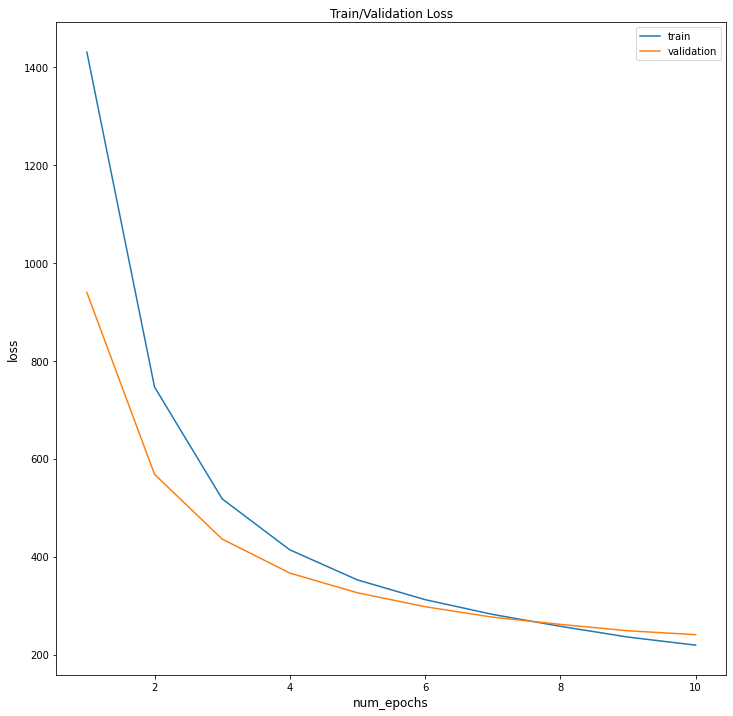

In [56]:
plot_graph(n_epochs)

### Run biLSTM 

In [59]:
n_epochs = 10
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_))) 
    # keep/store predictions
    with torch.no_grad(): # You should use no_grad session when you evaluate the model. (It is much faster!)
      for i, (x_batch, y_batch) in enumerate(valid_loader): 
          y_pred = model(x_batch).detach()
          val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred, dim=1).cpu().numpy()
          avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
          # avg_val_loss += loss.item() / len(train_loader)
    
    # Check Accuracy
    pred_y = val_preds.argmax(axis=1) 
    import sklearn.metrics
    # val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    f1 = sklearn.metrics.f1_score(y_true=test_y,y_pred=pred_y,average='macro')
    auc = sklearn.metrics.roc_auc_score(y_true=test_y,y_score=val_preds,multi_class='ovr')

    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f} \t f1={:.4f} \t auc={:.4f} \t time={:.2f}s'.format(
        epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, f1, auc, elapsed_time))

Epoch 1/10 	 loss=1907.2467 	 val_loss=1549.7529  	 val_acc=0.2901 	 f1=0.0394 	 auc=0.8206 	 time=28.49s
Epoch 2/10 	 loss=1326.9770 	 val_loss=1059.3453  	 val_acc=0.5029 	 f1=0.1584 	 auc=0.9315 	 time=29.14s
Epoch 3/10 	 loss=956.2236 	 val_loss=785.6573  	 val_acc=0.6309 	 f1=0.3154 	 auc=0.9660 	 time=27.16s
Epoch 4/10 	 loss=748.2835 	 val_loss=638.5461  	 val_acc=0.6996 	 f1=0.4367 	 auc=0.9772 	 time=27.79s
Epoch 5/10 	 loss=615.9793 	 val_loss=533.2722  	 val_acc=0.7384 	 f1=0.5220 	 auc=0.9829 	 time=28.44s
Epoch 6/10 	 loss=528.3821 	 val_loss=468.4903  	 val_acc=0.7697 	 f1=0.6123 	 auc=0.9860 	 time=27.69s
Epoch 7/10 	 loss=466.4506 	 val_loss=434.2754  	 val_acc=0.7884 	 f1=0.6454 	 auc=0.9874 	 time=27.59s
Epoch 8/10 	 loss=422.7111 	 val_loss=399.1803  	 val_acc=0.8057 	 f1=0.6916 	 auc=0.9892 	 time=27.71s
Epoch 9/10 	 loss=378.4443 	 val_loss=366.8725  	 val_acc=0.8240 	 f1=0.7379 	 auc=0.9905 	 time=27.66s
Epoch 10/10 	 loss=351.5766 	 val_loss=354.8829  	 val_acc=0

In [60]:
torch.save(model,'bilstm_model')

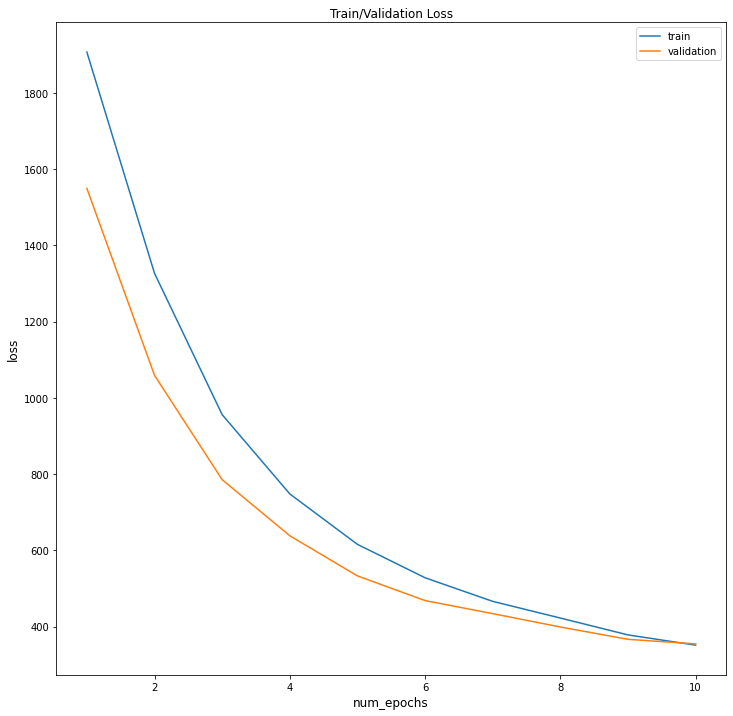

In [61]:
plot_graph(n_epochs)

F1 / AUROC Evaluation

In [63]:
model.eval()        
avg_val_loss = 0.
val_preds = np.zeros((len(x_cv),len(le.classes_))) 
# keep/store predictions
with torch.no_grad(): # You should use no_grad session when you evaluate the model. (It is much faster!)
  for i, (x_batch, y_batch) in enumerate(valid_loader): 
      y_pred = model(x_batch).detach()
      val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred, dim=1).cpu().numpy()

# Check Accuracy
pred_y = val_preds.argmax(axis=1) 
import sklearn.metrics
# val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
acc = sklearn.metrics.accuracy_score(y_pred=pred_y,y_true=test_y)
f1 = sklearn.metrics.f1_score(y_true=test_y,y_pred=pred_y,average='macro')
auc = sklearn.metrics.roc_auc_score(y_true=test_y,y_score=val_preds,multi_class='ovr')
prec = sklearn.metrics.precision_score(y_true=test_y,y_pred=pred_y,average='macro')
recall = sklearn.metrics.recall_score(y_true=test_y,y_pred=pred_y,average='macro')
print(acc,f1,auc,prec,recall)

0.8225966303270565 0.7413586022202234 0.9910415658526386 0.7995641908079294 0.7188898750139394


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
